In [28]:
#https://www.kaggle.com/anikannal/solar-power-generation-data/tasks

In [29]:
import pandas as pd
import numpy as np
%matplotlib inline

In [30]:
full = pd.read_parquet("full_direct_df.parquet").sort_values("DATE_TIME")

In [31]:
full.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
0     2020-05-15   4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0   
59333 2020-05-15   4135001  z9Y9gH1T5YWrNuG       0.0       0.0          0.0   
56211 2020-05-15   4135001  wCURE6d3bPkepu2       0.0       0.0          0.0   
53090 2020-05-15   4135001  uHbuxQJl8lW7ozc       0.0       0.0          0.0   
49970 2020-05-15   4135001  sjndEbLyjtCKgGv       0.0       0.0          0.0   

       TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
0        6259559.0            25.184316           22.857507          0.0   
59333    7007866.0            25.184316           22.857507          0.0   
56211    6782598.0            25.184316           22.857507          0.0   
53090    7038681.0            25.184316           22.857507          0.0   
49970    7016832.0            25.184316           22.857507          0.0   

       15M_YIELD   Y4  
0            0.0  0.0  
59333        0.0  0.0  
56211        0.0  0.0  
53090        0.0  0.0  
49970        0.0  0.0

# Split

In [32]:
full['DATE_TIME'].describe()

/home/ubuntu/anaconda3/envs/rapids_p37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   68690
unique                   3154
top       2020-05-25 15:45:00
freq                       22
first     2020-05-15 00:00:00
last      2020-06-17 22:45:00
Name: DATE_TIME, dtype: object

In [33]:
full.groupby(full['DATE_TIME'].dt.month).size()

DATE_TIME
5    33112
6    35578
dtype: int64

In [34]:
split_date = "2020-06-01"
train = full[full['DATE_TIME'] < split_date]
val = full[full['DATE_TIME'] >= split_date]
train.shape, val.shape

((33112, 12), (35578, 12))

In [60]:
winsor_lower = np.percentile(train['Y4'], 1) # 0.1, 1, 5, 10?
winsor_upper = np.percentile(train['Y4'], 99)
train['Y4WIN'] = train['Y4'].clip(lower=winsor_lower, upper=winsor_upper)

train.reset_index().to_parquet("train.parquet")
val.reset_index().to_parquet("val.parquet")

/home/ubuntu/anaconda3/envs/rapids_p37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Baseline

In [10]:
train2 = train.copy()
train2['WEEKDAY'] = train2['DATE_TIME'].dt.weekday
train2['HOUR'] = train2['DATE_TIME'].dt.hour
train2['MINUTE'] = train2['DATE_TIME'].dt.minute

base_pred = train2.groupby(['WEEKDAY','HOUR', 'MINUTE'], as_index=False)['Y4'].mean()
base_pred = base_pred.rename(columns={"Y4": "P"}) # 15M_YIELD?

In [37]:
base_pred

WEEKDAY  HOUR  MINUTE           P
0          0     0       0    0.000000
1          0     0      15    0.000000
2          0     0      30    0.000000
3          0     0      45    0.000000
4          0     1       0    0.000000
..       ...   ...     ...         ...
667        6    22      45 -539.571429
668        6    23       0    0.000000
669        6    23      15    0.000000
670        6    23      30    0.000000
671        6    23      45    0.000000

[672 rows x 4 columns]

In [38]:
val2 = val.copy()
val2['WEEKDAY'] = val2['DATE_TIME'].dt.weekday
val2['HOUR'] = val2['DATE_TIME'].dt.hour
val2['MINUTE'] = val2['DATE_TIME'].dt.minute

val2 = pd.merge(val2, base_pred, on=['WEEKDAY', 'HOUR', 'MINUTE'])
val2.head()

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
0 2020-06-01   4135001  VHMLBKoKgIrUVDU       0.0       0.0      759.500   
1 2020-06-01   4135001  7JYdWkrLSPkdwr4       0.0       0.0      730.375   
2 2020-06-01   4135001  ZnxXDlPa8U1GXgE       0.0       0.0      767.750   
3 2020-06-01   4135001  zBIq5rxdHJRwDNY       0.0       0.0        0.000   
4 2020-06-01   4135001  uHbuxQJl8lW7ozc       0.0       0.0        0.000   

   TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION  \
0    7334405.0            23.128673           20.464305          0.0   
1    7727821.0            23.128673           20.464305          0.0   
2    6649525.0            23.128673           20.464305          0.0   
3    6463239.0            23.128673           20.464305          0.0   
4    7165353.0            23.128673           20.464305          0.0   

   15M_YIELD   Y4  WEEKDAY  HOUR  MINUTE    P  
0        0.0  0.0        0     0       0  0.0  
1        0.0  0.0        0     0       0  0.0  
2        0.0  0.0        0     0       0  0.0  
3        0.0  0.0        0     0       0  0.0  
4        0.0  0.0        0     0       0  0.0

In [14]:
from sklearn.metrics import median_absolute_error
median_absolute_error(val2['Y4'],val2['P'])

3.6137718302274564

<AxesSubplot:>

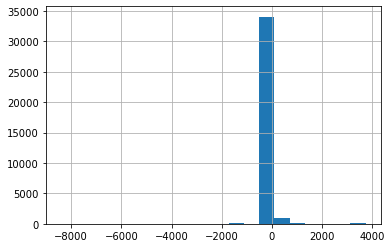

In [15]:
(val2['Y4']-val2['P']).hist(bins=20)

# Baseline ML

In [44]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD']

from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train[features].fillna(-1), train['Y4']
mdl.fit(Xtr,ytr)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [45]:
p = mdl.predict(val[features].fillna(-1))
median_absolute_error(val['Y4'], p)

7.319553472999985

# 1. Lag
- pq não posso fazer com Y4? só sei esse valor daqui a 4 períodos!

In [46]:
lags = [1,4,8,16]

train2 = list()
new_features = set()

features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD']

for source_key, source_key_df in train.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            source_key_df['LAG{}_{}'.format(l, f)] = source_key_df[f].shift(l)
        
    train2.append(source_key_df)
train2 = pd.concat(train2, ignore_index=True)


val2 = list()
for source_key, source_key_df in val.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            source_key_df['LAG{}_{}'.format(l, f)] = source_key_df[f].shift(l)
        
    val2.append(source_key_df)
val2 = pd.concat(val2, ignore_index=True)

In [47]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD'] + list(new_features)

from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']
mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))
median_absolute_error(val2['Y4'], p)

7.000178603499954

## EXTRA: Leakage

In [20]:
train2[train2['SOURCE_KEY'] == '1BY6WEcLGh8j5v7'][['DATE_TIME', 'SOURCE_KEY','15M_YIELD','Y4']].iloc[15:30]

DATE_TIME       SOURCE_KEY  15M_YIELD         Y4
15 2020-05-15 03:45:00  1BY6WEcLGh8j5v7   0.000000   0.000000
16 2020-05-15 04:00:00  1BY6WEcLGh8j5v7   0.000000   0.000000
17 2020-05-15 04:15:00  1BY6WEcLGh8j5v7   0.000000   0.000000
18 2020-05-15 04:30:00  1BY6WEcLGh8j5v7   0.000000   0.000000
19 2020-05-15 04:45:00  1BY6WEcLGh8j5v7   0.000000   0.000000
20 2020-05-15 05:00:00  1BY6WEcLGh8j5v7   0.000000   0.000000
21 2020-05-15 05:15:00  1BY6WEcLGh8j5v7   0.000000   2.625000
22 2020-05-15 05:30:00  1BY6WEcLGh8j5v7   0.000000  10.660714
23 2020-05-15 05:45:00  1BY6WEcLGh8j5v7   0.000000  21.589286
24 2020-05-15 06:00:00  1BY6WEcLGh8j5v7   0.000000  37.839286
25 2020-05-15 06:15:00  1BY6WEcLGh8j5v7   2.625000  43.535714
26 2020-05-15 06:30:00  1BY6WEcLGh8j5v7  10.660714  46.178571
27 2020-05-15 06:45:00  1BY6WEcLGh8j5v7  21.589286  43.946429
28 2020-05-15 07:00:00  1BY6WEcLGh8j5v7  37.839286  57.196429
29 2020-05-15 07:15:00  1BY6WEcLGh8j5v7  43.535714  96.303571

# 2. Diff

In [48]:
lags = [1,4,8,16]

train2 = list()
new_features = set()

features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD']

for source_key, source_key_df in train.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            new_features.add('DIFF{}_{}'.format(l, f))
            source_key_df['DIFF{}_{}'.format(l, f)] = source_key_df[f].diff(l)
        
    train2.append(source_key_df)
train2 = pd.concat(train2, ignore_index=True)


val2 = list()
for source_key, source_key_df in val.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            source_key_df['DIFF{}_{}'.format(l, f)] = source_key_df[f].diff(l)
        
    val2.append(source_key_df)
val2 = pd.concat(val2, ignore_index=True)

In [49]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD'] + list(new_features)

from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']
mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))
median_absolute_error(val2['Y4'], p)

7.670833364500012

# 3. Rolling statistics

In [50]:
lags = [1,4,8,16]

train2 = list()
new_features = set()

features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD']

for source_key, source_key_df in train.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            source_key_df['ROLL_MEAN{}_{}'.format(l, f)] = source_key_df[f].rolling(l).mean()
        
    train2.append(source_key_df)
train2 = pd.concat(train2, ignore_index=True)


val2 = list()
for source_key, source_key_df in val.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            source_key_df['ROLL_MEAN{}_{}'.format(l, f)] = source_key_df[f].rolling(l).mean()
        
    val2.append(source_key_df)
val2 = pd.concat(val2, ignore_index=True)

In [51]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD'] + list(new_features)

from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']
mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))
median_absolute_error(val2['Y4'], p)

9.176785704850033

# 3.1 EXTRA: Current minus Rolling (Delta Roll)

In [52]:
 
lags = [1,4,8,16]

train2 = list()
new_features = set()

features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD']

for source_key, source_key_df in train.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            source_key_df['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = source_key_df[f] - source_key_df[f].rolling(l).mean()
        
    train2.append(source_key_df)
train2 = pd.concat(train2, ignore_index=True)


val2 = list()
for source_key, source_key_df in val.groupby("SOURCE_KEY"):
    source_key_df = source_key_df.copy()
    for f in features:
        for l in lags:
            source_key_df['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = source_key_df[f] - source_key_df[f].rolling(l).mean()
        
    val2.append(source_key_df)
val2 = pd.concat(val2, ignore_index=True)

In [53]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD'] + list(new_features)

from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']
mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))
median_absolute_error(val2['Y4'], p)

8.361368401059588

# 4. Date components + features

In [54]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD', 
            'WEEKDAY', 'HOUR', 'MINUTE']

train2 = train.copy()
train2['WEEKDAY'] = train2['DATE_TIME'].dt.weekday
train2['HOUR'] = train2['DATE_TIME'].dt.hour
train2['MINUTE'] = train2['DATE_TIME'].dt.minute

val2 = val.copy()
val2['WEEKDAY'] = val2['DATE_TIME'].dt.weekday
val2['HOUR'] = val2['DATE_TIME'].dt.hour
val2['MINUTE'] = val2['DATE_TIME'].dt.minute

from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']
mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))
median_absolute_error(val2['Y4'], p)

3.892678490499506

# 4.1 Date components sem features

In [55]:
features = ['WEEKDAY', 'HOUR', 'MINUTE']

train2 = train.copy()
train2['WEEKDAY'] = train2['DATE_TIME'].dt.weekday
train2['HOUR'] = train2['DATE_TIME'].dt.hour
train2['MINUTE'] = train2['DATE_TIME'].dt.minute

val2 = val.copy()
val2['WEEKDAY'] = val2['DATE_TIME'].dt.weekday
val2['HOUR'] = val2['DATE_TIME'].dt.hour
val2['MINUTE'] = val2['DATE_TIME'].dt.minute

from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4']
mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))
median_absolute_error(val2['Y4'], p)

3.637201504560414

# EXTRA: Winsorize

In [59]:
features = ['DC_POWER', 'AC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', '15M_YIELD', 
            'WEEKDAY', 'HOUR', 'MINUTE']

train2 = train.copy()
train2['WEEKDAY'] = train2['DATE_TIME'].dt.weekday
train2['HOUR'] = train2['DATE_TIME'].dt.hour
train2['MINUTE'] = train2['DATE_TIME'].dt.minute

winsor_lower = np.percentile(train2['Y4'], 1) # 0.1, 1, 5, 10?
winsor_upper = np.percentile(train2['Y4'], 99)
train2['Y4WIN'] = train2['Y4'].clip(lower=winsor_lower, upper=winsor_upper)

val2 = val.copy()
val2['WEEKDAY'] = val2['DATE_TIME'].dt.weekday
val2['HOUR'] = val2['DATE_TIME'].dt.hour
val2['MINUTE'] = val2['DATE_TIME'].dt.minute

#val2['Y4WIN'] = val2['Y4'].clip(lower=winsor_lower, upper=winsor_upper)

from sklearn.ensemble import RandomForestRegressor
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=100)

Xtr, ytr = train2[features].fillna(-1), train2['Y4WIN']
mdl.fit(Xtr,ytr)

p = mdl.predict(val2[features].fillna(-1))
median_absolute_error(val2['Y4'], p)

2.401744282500254